# Setup

In [15]:
%pip install control

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import skfuzzy as fuzz

def gerar_tabela_verdade(fuzzy_sim, e, delta_e, delta_u):
    # Gerando todas as combinações de entradas e calculando as saídas
    results = []
    for e_val in e.terms:
        row = []
        for delta_e_val in delta_e.terms:
            fuzzy_sim.input["e"] = e_val
            fuzzy_sim.input["delta_e"] = delta_e_val
            fuzzy_sim.compute()
            delta_u_val = fuzzy_sim.output["delta_u"]
            
            # Convertendo o valor de saída para o rótulo correspondente
            membership_values = {}
            for label in delta_u.terms:
                membership_values[label] = fuzz.interp_membership(
                    delta_u.universe, delta_u[label].mf, delta_u_val
                )
            label = max(membership_values, key=membership_values.get)
            row.append(label)
        results.append(row)

    # Criando um DataFrame com os resultados
    columns = delta_e.terms.keys()
    index = e.terms.keys()
    df = pd.DataFrame(results, columns=columns, index=index)

    # Adicionando a coluna de índice como "e[k] / Δe[k]"
    df.columns.name = "e[k] / Δe[k]"

    return df

In [ ]:
from math import pi
from numpy import array, identity, arange
import matplotlib.pyplot as plt

# Definição dos parâmetros do motor
Pmec = 95 * 10**3
n = 0.913
Vn = 400
Wn = 1890 * pi / 30
Ra = 0.08
J = 0.56
La = 1.4 * 10**-3

Pele = Pmec / n
Cmn = Pmec / Wn
Ian = Pele / Vn
Kf = (Vn - Ian * Ra) / Wn
B = (Kf * Ian - Cmn) / Wn
Tm = J / B
Te = La / Ra
T = Te / 10

# Definição das matrizes A, B e C
A = array([[1 - T / Te, -Kf * T / La], [Kf * T / J, 1 - T / Tm]])
B = array([[T / La, 0], [0, -T / J]])


def simular_resposta_fuzzy(fuzzy_sim, setpoint, com_delta_e=True):
    # Definindo parâmetros da simulação
    x = array([[0], [0]])
    u = array([[0], [0]])
    W, Ia, t = [0], [0], [0]
    tempo = 0
    N = int(3 / T)
    errors = [0]
    delta_errors = [0]
    signals = [0]
    voltage = [0]

    for i in range(0, N):
        # Compute the error
        curr_error = (setpoint - W[-1])/setpoint * 100

        # Set the input to the fuzzy controller
        fuzzy_sim.input["e"] = curr_error
        if com_delta_e: 
            delta_error = 0 if len(errors) == 0 else errors[-1] - curr_error
            fuzzy_sim.input["delta_e"] = delta_error
            delta_errors.append(delta_error)

        # Compute the fuzzy control signal
        fuzzy_sim.compute()

        # Get the control signal from the fuzzy controller
        volt = 400 if len(voltage) == 0 else voltage[-1]
        control_signal_current = signals[-1] + fuzzy_sim.output["delta_u"]
        print(volt)

        u.put(0, control_signal_current)

        # Calculando as saídas e armazenando-as
        x = A.dot(x) + B.dot(u)

        Ia.append(x[0].item())
        W.append(x[1].item())

        # Incrementando e armazenando o tempo de simulação
        tempo += T
        t.append(tempo)
        errors.append(curr_error)
        signals.append(control_signal_current)
        voltage.append(volt)

    # Mostrando os gráficos de velocidade, corrente, erros e sinais em uma matriz 2x2
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

    # Gráfico de Velocidade
    ax1.plot(t, W, color="r")
    ax1.set_title("Velocidade do eixo")
    ax1.set_xlabel("Tempo (s)")
    ax1.set_ylabel("Velocidade (rad/s)")
    ax1.set_yticks(arange(min(W), max(W) + 20, 15))
    ax1.tick_params(axis="y", labelsize=8)
    ax1.legend(["Velocidade"])

    # Gráfico de Sinais de Controle
    ax2.plot(t, signals, color="m")
    ax2.set_title("Sinais de Controle")
    ax2.set_xlabel("Tempo (s)")
    ax2.set_ylabel("Sinal de Controle")
    ax2.legend(["Sinal de Controle"])

    # Gráfico de Erros
    ax3.plot(t, errors, color="g")
    ax3.set_title("Erros")
    ax3.set_xlabel("Tempo (s)")
    ax3.set_ylabel("Erro")
    ax3.legend(["Erro"])

    # Gráfico de Delta Erros
    ax4.plot(t, delta_errors, color="c")
    ax4.set_title("Delta Erros")
    ax4.set_xlabel("Tempo (s)")
    ax4.set_ylabel("Delta Erro")
    ax4.legend(["Delta Erro"])

    plt.tight_layout()
    plt.show()

# Controle PI tradicional

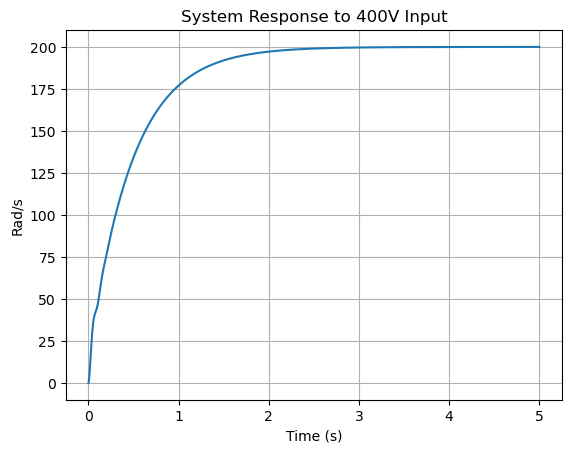

In [ ]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Define the sampling time
T = 0.00175

# Define the transfer functions
num_gpz = [0.0058540, 0, 0]
den_gpz = [1, -1.9224928, 0.9337476]

gpz = ct.TransferFunction(num_gpz, den_gpz, T)
gpi = 0.15 * ct.TransferFunction([1, -0.95], [1, -1], T)
# gpid = 1 * ctrl.TransferFunction([1, -0.2], [1, -0.1], T)

# Compute the closed-loop transfer function
sys_open_loop = ct.series(gpz, gpi)  # C(s) * G(s)
sys_closed_loop = ct.feedback(sys_open_loop, 1)

# Root locus plot
# Simulate system response to a 400V input and 0 load
time = np.arange(0, 5, T)
T_out, yout = ct.forced_response(sys_closed_loop, T=time, U=np.ones_like(time)*200)

# Plot the response
plt.figure()
plt.plot(T_out, yout)
plt.xlabel('Time (s)')
plt.ylabel('Rad/s')
plt.title('System Response to 400V Input')
plt.grid()
plt.show()

# Controle PI Fuzzy

Defuzzified value: -355.55554444304687

Membership of 'NG': 0.6666665833229273
Membership of 'NM': 0.3333334166770728
Membership of 'NP': 0.0
Membership of 'ZE': 0.0
Membership of 'PP': 0.0
Membership of 'PM': 0.0
Membership of 'PG': 0.0


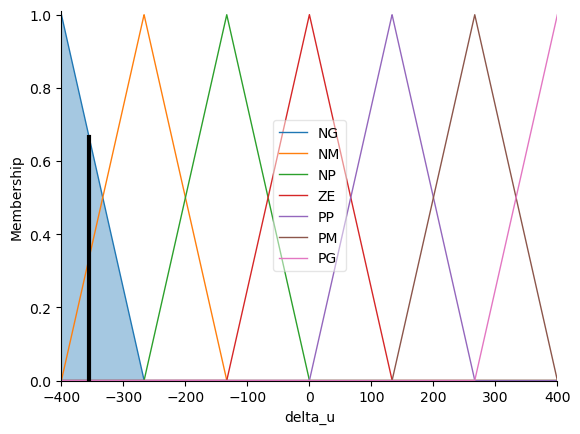

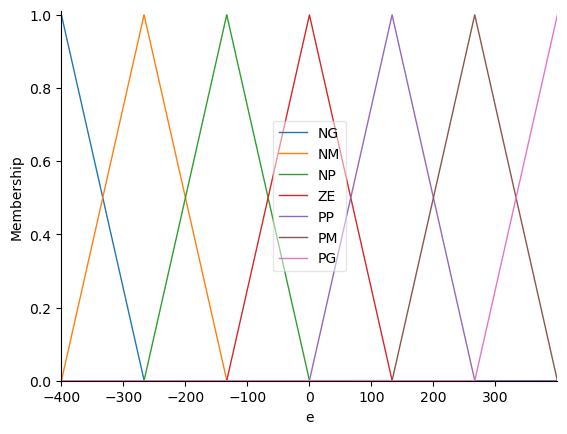

In [ ]:
import numpy as np
from skfuzzy import control as ctrl

# Definindo as variáveis fuzzy
e = ctrl.Antecedent(np.arange(-400, 400, 0.1), 'e')
delta_e = ctrl.Antecedent(np.arange(-50, 50, 0.1), 'delta_e')
delta_u = ctrl.Consequent(np.arange(-400, 400.1, 0.1),'delta_u')

# Definindo as funções de pertinência

CODIGOS = ['NG', 'NM', 'NP', 'ZE', 'PP', 'PM', 'PG']

e.automf(names=CODIGOS)
delta_e.automf(names=CODIGOS)
delta_u.automf(names=CODIGOS)

# Criando as regras fuzzy
rules_1 = [
    ctrl.Rule(e['NG'] & delta_e['NG'], delta_u['NG']),
    ctrl.Rule(e['NG'] & delta_e['NM'], delta_u['NG']),
    ctrl.Rule(e['NG'] & delta_e['NP'], delta_u['NG']),
    ctrl.Rule(e['NG'] & delta_e['ZE'], delta_u['NG']),
    ctrl.Rule(e['NG'] & delta_e['PP'], delta_u['NM']),
    ctrl.Rule(e['NG'] & delta_e['PM'], delta_u['NP']),
    ctrl.Rule(e['NG'] & delta_e['PG'], delta_u['ZE']),

    ctrl.Rule(e['NM'] & delta_e['NG'], delta_u['NG']),
    ctrl.Rule(e['NM'] & delta_e['NM'], delta_u['NG']),
    ctrl.Rule(e['NM'] & delta_e['NP'], delta_u['NG']),
    ctrl.Rule(e['NM'] & delta_e['ZE'], delta_u['NM']),
    ctrl.Rule(e['NM'] & delta_e['PP'], delta_u['NP']),
    ctrl.Rule(e['NM'] & delta_e['PM'], delta_u['ZE']),
    ctrl.Rule(e['NM'] & delta_e['PG'], delta_u['PP']),

    ctrl.Rule(e['NP'] & delta_e['NG'], delta_u['NG']),
    ctrl.Rule(e['NP'] & delta_e['NM'], delta_u['NG']),
    ctrl.Rule(e['NP'] & delta_e['NP'], delta_u['NM']),
    ctrl.Rule(e['NP'] & delta_e['ZE'], delta_u['NP']),
    ctrl.Rule(e['NP'] & delta_e['PP'], delta_u['ZE']),
    ctrl.Rule(e['NP'] & delta_e['PM'], delta_u['PP']),
    ctrl.Rule(e['NP'] & delta_e['PG'], delta_u['PM']),

    ctrl.Rule(e['ZE'] & delta_e['NG'], delta_u['NG']),
    ctrl.Rule(e['ZE'] & delta_e['NM'], delta_u['NM']),
    ctrl.Rule(e['ZE'] & delta_e['NP'], delta_u['NP']),
    ctrl.Rule(e['ZE'] & delta_e['ZE'], delta_u['ZE']),
    ctrl.Rule(e['ZE'] & delta_e['PP'], delta_u['PP']),
    ctrl.Rule(e['ZE'] & delta_e['PM'], delta_u['PM']),
    ctrl.Rule(e['ZE'] & delta_e['PG'], delta_u['PG']),

    ctrl.Rule(e['PP'] & delta_e['NG'], delta_u['NM']),
    ctrl.Rule(e['PP'] & delta_e['NM'], delta_u['NP']),
    ctrl.Rule(e['PP'] & delta_e['NP'], delta_u['ZE']),
    ctrl.Rule(e['PP'] & delta_e['ZE'], delta_u['PP']),
    ctrl.Rule(e['PP'] & delta_e['PP'], delta_u['PM']),
    ctrl.Rule(e['PP'] & delta_e['PM'], delta_u['PG']),
    ctrl.Rule(e['PP'] & delta_e['PG'], delta_u['PG']),

    ctrl.Rule(e['PM'] & delta_e['NG'], delta_u['NP']),
    ctrl.Rule(e['PM'] & delta_e['NM'], delta_u['ZE']),
    ctrl.Rule(e['PM'] & delta_e['NP'], delta_u['PP']),
    ctrl.Rule(e['PM'] & delta_e['ZE'], delta_u['PM']),
    ctrl.Rule(e['PM'] & delta_e['PP'], delta_u['PG']),
    ctrl.Rule(e['PM'] & delta_e['PM'], delta_u['PG']),
    ctrl.Rule(e['PM'] & delta_e['PG'], delta_u['PG']),

    ctrl.Rule(e['PG'] & delta_e['NG'], delta_u['ZE']),
    ctrl.Rule(e['PG'] & delta_e['NM'], delta_u['PP']),
    ctrl.Rule(e['PG'] & delta_e['NP'], delta_u['PM']),
    ctrl.Rule(e['PG'] & delta_e['ZE'], delta_u['PG']),
    ctrl.Rule(e['PG'] & delta_e['PP'], delta_u['PG']),
    ctrl.Rule(e['PG'] & delta_e['PM'], delta_u['PG']),
    ctrl.Rule(e['PG'] & delta_e['PG'], delta_u['PG'])
]

# e.automf(names=['NG', 'NP', 'ZE', 'PP', 'PG'])
# delta_e.automf(names=['NG', 'NP', 'ZE', 'PP', 'PG'])
# delta_u.automf(names=['NMG', 'NG', "NM", 'NP', 'ZE', 'PP', "PM", 'PG', 'PMG'])

# rules_2 = [
#     ctrl.Rule(e['NG'] & delta_e['NG'], delta_u['PMG']),
#     ctrl.Rule(e['NG'] & delta_e['NP'], delta_u['PG']),
#     ctrl.Rule(e['NG'] & delta_e['ZE'], delta_u['PM']),
#     ctrl.Rule(e['NG'] & delta_e['PP'], delta_u['PP']),
#     ctrl.Rule(e['NG'] & delta_e['PG'], delta_u['ZE']),

#     ctrl.Rule(e['NP'] & delta_e['NG'], delta_u['PG']),
#     ctrl.Rule(e['NP'] & delta_e['NP'], delta_u['PM']),
#     ctrl.Rule(e['NP'] & delta_e['ZE'], delta_u['PP']),
#     ctrl.Rule(e['NP'] & delta_e['PP'], delta_u['ZE']),
#     ctrl.Rule(e['NP'] & delta_e['PG'], delta_u['NP']),

#     ctrl.Rule(e['ZE'] & delta_e['NG'], delta_u['PM']),
#     ctrl.Rule(e['ZE'] & delta_e['NP'], delta_u['PP']),
#     ctrl.Rule(e['ZE'] & delta_e['ZE'], delta_u['ZE']),
#     ctrl.Rule(e['ZE'] & delta_e['PP'], delta_u['NP']),
#     ctrl.Rule(e['ZE'] & delta_e['PG'], delta_u['NM']),

#     ctrl.Rule(e['PP'] & delta_e['NG'], delta_u['PP']),
#     ctrl.Rule(e['PP'] & delta_e['NP'], delta_u['ZE']),
#     ctrl.Rule(e['PP'] & delta_e['ZE'], delta_u['NP']),
#     ctrl.Rule(e['PP'] & delta_e['PP'], delta_u['NM']),
#     ctrl.Rule(e['PP'] & delta_e['PG'], delta_u['NG']),

#     ctrl.Rule(e['PG'] & delta_e['NG'], delta_u['ZE']),
#     ctrl.Rule(e['PG'] & delta_e['NP'], delta_u['NP']),
#     ctrl.Rule(e['PG'] & delta_e['ZE'], delta_u['NM']),
#     ctrl.Rule(e['PG'] & delta_e['PP'], delta_u['NG']),
#     ctrl.Rule(e['PG'] & delta_e['PG'], delta_u['NMG'])
# ]

# Criando o sistema de controle
control_system = ctrl.ControlSystem(rules_1)

# Simulando o sistema
fuzzy_sim = ctrl.ControlSystemSimulation(control_system)

# Definindo entradas e computando
fuzzy_sim.input['e'] = "NG"
fuzzy_sim.input['delta_e'] = "NG"
fuzzy_sim.compute()

# Obtendo o resultado
fuzzy_sim.output['delta_u']

print(f"Defuzzified value: {fuzzy_sim.output['delta_u']}\n")
for label in delta_u.terms:
    membership_value = fuzz.interp_membership(delta_u.universe, delta_u[label].mf, fuzzy_sim.output["delta_u"])
    print(f"Membership of '{label}': {membership_value}")

delta_u.view(sim=fuzzy_sim);

e.view()


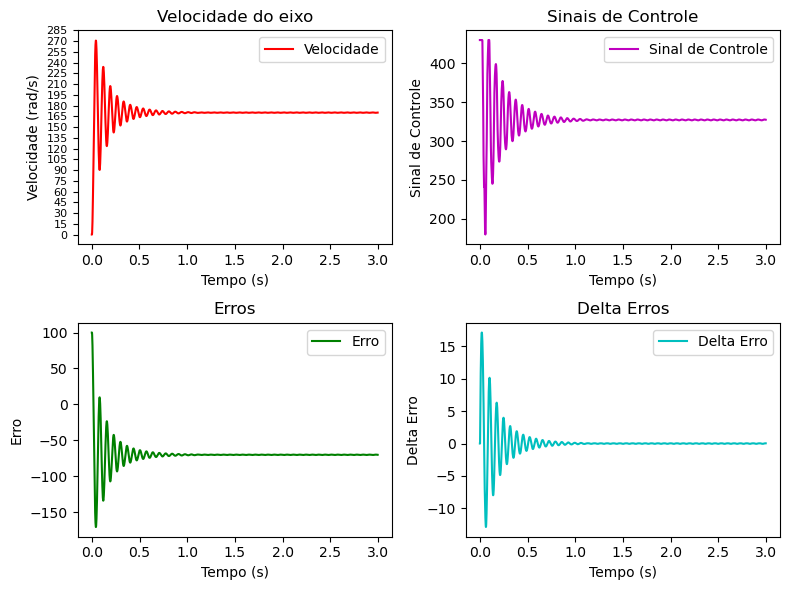

# Teste

Defuzzified value: -0.3495239535618335

{'NG': 0.0, 'NM': 0.0, 'NP': 0.00224671049120689, 'ZE': 0.9977532895087929, 'PP': 0.0, 'PM': 0.0, 'PG': 0.0}


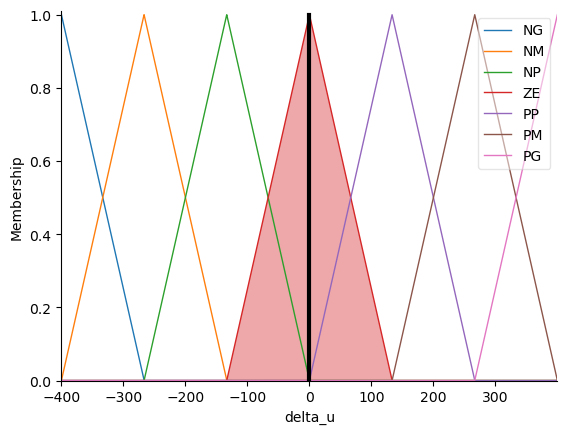

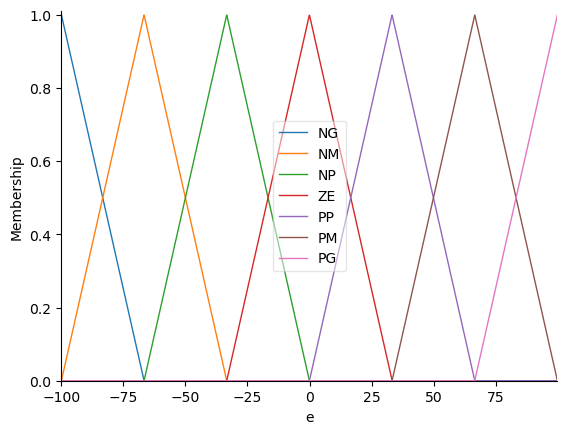

In [55]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Definindo as variáveis fuzzy
e = ctrl.Antecedent(np.arange(-100, 100, 0.1), 'e')
delta_u = ctrl.Consequent(np.arange(-400, 400, 0.1),'delta_u')

# Definindo as funções de pertinência
CODIGOS = ['NG', 'NM', 'NP', 'ZE', 'PP', 'PM', 'PG']

e.automf(names=CODIGOS)
delta_u.automf(names=CODIGOS)
# e['NG'] = fuzz.trimf(e.universe, [-100, -100, -60])
# e['NM'] = fuzz.trimf(e.universe, [-75, -45, -15])
# e['NP'] = fuzz.trimf(e.universe, [-30, -15, 0])
# e['ZE'] = fuzz.trimf(e.universe, [-2, 0, 2])
# e['PP'] = fuzz.trimf(e.universe, [0, 15, 30])
# e['PM'] = fuzz.trimf(e.universe, [15, 45, 75])
# e['PG'] = fuzz.trimf(e.universe, [60, 100, 100])


# delta_u['ZE'] = fuzz.trimf(delta_u.universe, [-202, -200, -198])

# Criando as regras fuzzy
rules = [
    ctrl.Rule(e['NG'], delta_u['PG']),
    ctrl.Rule(e['NM'], delta_u['PM']),
    ctrl.Rule(e['NP'], delta_u['PP']),
    ctrl.Rule(e['ZE'], delta_u['ZE']),
    ctrl.Rule(e['PG'], delta_u['NG']),
    ctrl.Rule(e['PM'], delta_u['NM']),
    ctrl.Rule(e['PP'], delta_u['NP']),
]

# Criando o sistema de controle
control_system = ctrl.ControlSystem(rules)

# Simulando o sistema
fuzzy_sim = ctrl.ControlSystemSimulation(control_system)

# Definindo entradas e computando
fuzzy_sim.input['e'] = 0
fuzzy_sim.compute()

# Obtendo o resultado
fuzzy_sim.output['delta_u']

print(f"Defuzzified value: {fuzzy_sim.output['delta_u']}\n")
m = {}
for label in delta_u.terms:
    membership_value = fuzz.interp_membership(delta_u.universe, delta_u[label].mf, fuzzy_sim.output["delta_u"])
    m[label] = membership_value

print(m)
delta_u.view(sim=fuzzy_sim);
e.view();

In [ ]:
simular_resposta_fuzzy(fuzzy_sim, 100, com_delta_e=False)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


ValueError: x and y must have same first dimension, but have shapes (1714,) and (1715,)